In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount = False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install tensorflow-gpu==2.2.0
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
print(tf.test.gpu_device_name())

     |████████████████████████████████| 516.2MB 31kB/s 
/device:GPU:0


In [3]:
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
########################################
np.random.seed(27)
tf.random.set_seed(27)
tf.compat.v1.reset_default_graph()
BATCH_SIZE = 1000
EPOCHS = 100
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta = 0.001, 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)
def plot_metrics(history):
  metrics =  ['accuracy', 'precision', 'recall','F1_score']
  plt.figure(figsize=(10,8))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color="b", label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color="r", linestyle="--", label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0.2,1])
    plt.legend(loc="best")


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            
    plt.xlim(xmax = len(target_names)-0.5)
    plt.ylim(4.5,-0.5)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    #plt.savefig('cm.pdf')
    plt.show()
def evaluate(predict):
    print("Test accuracy = ",sum(predict[0] == predict[1])/len(predict[0]))
    print("mu =" , np.mean(predict[0]-predict[1]))
    print("sigma = ",np.std(predict[0]-predict[1]))
    print("RMSE = ",np.sqrt(np.mean((predict[0]-predict[1])**2)))
    print("1st order poly fit:", np.polyfit(predict[0],predict[1],deg=1))
def micro_scores(cm):
    precision = np.zeros((len(cm)))
    recall = np.zeros((len(cm)))
    F1score = np.zeros((len(cm)))
    for i in range(len(cm)):
        precision[i] = cm[i,i]/sum(cm[:,i])
        recall[i] = cm[i,i]/sum(cm[i,:])
        F1score[i] = 2*precision[i]*recall[i]/(precision[i]+recall[i])
    print("print percisions; recalls; F1 scores")
    print(precision)
    print(recall)
    print(F1score)
    return precision, recall, F1score

In [4]:
# load data  
# split train and test
from sklearn.model_selection import train_test_split
obsid_all = np.load('/content/drive/My Drive/CNN_spectra_data/LAMOST_dr5_SNR100_obsid.npy')
spectra_all = np.load('/content/drive/My Drive/CNN_spectra_data/LAMOST_dr5_SNR100_spectra.npy')
obsid_classlabel = np.genfromtxt('/content/drive/My Drive/CNN_spectra_data/dr5_SNR100_obsid_classlabel.csv'\
                                 ,delimiter=",",dtype=int)
unique_classes, counts_unique_classes = np.unique(obsid_classlabel[:,1], return_counts = True)
print(dict(zip(unique_classes,counts_unique_classes)))

num_spectra = len(obsid_classlabel)
spectra_NN = np.zeros((num_spectra,len(spectra_all[0])))
for i in range(num_spectra):
    index_of_spectra = np.where(obsid_all == obsid_classlabel[i][0])
    spectra_NN[i] = spectra_all[index_of_spectra]
spectra_train, spectra_val_test, label_train, label_val_test = train_test_split(spectra_NN,
                                                    obsid_classlabel[:,1]-1,
                                                    test_size = 0.2,
                                                    random_state = 27)
x_train = np.expand_dims(spectra_train,axis=2)
x_val_test = np.expand_dims(spectra_val_test,axis=2)
y_train = tf.one_hot(label_train, depth = 5, axis = 1 ,dtype=tf.int8)
y_val_test = tf.one_hot(label_val_test, depth = 5, axis = 1 ,dtype=tf.int8)

val_amount = int(len(x_val_test)/4)
x_val = x_val_test[:val_amount]
y_val = y_val_test[:val_amount]

x_test = x_val_test[val_amount:]
y_test = y_val_test[val_amount:]
label_test = label_val_test[val_amount:]
print(len(y_train))
print(len(y_val))
print(len(y_test))

{1: 1256, 2: 14870, 3: 23223, 4: 5585, 5: 63}
35997
2250
6750


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 4096, 1)           4         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 8192)              33562624  
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              16779264  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1

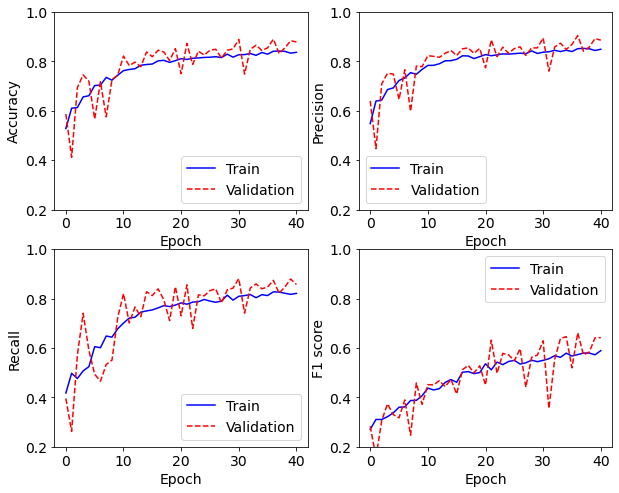

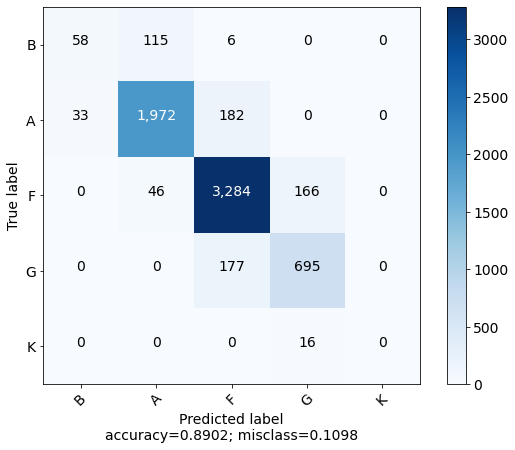

In [ ]:
model_MLP = tf.keras.Sequential()
model_MLP.add(tf.keras.layers.BatchNormalization(axis=-1,input_shape =(len(spectra_NN[0]),1)))
model_MLP.add(tf.keras.layers.Flatten())
model_MLP.add(tf.keras.layers.Dense(4096*2,activation="relu"))
model_MLP.add(tf.keras.layers.Dropout(0.2))
model_MLP.add(tf.keras.layers.Dense(2048,activation="relu"))
model_MLP.add(tf.keras.layers.Dropout(0.2))
model_MLP.add(tf.keras.layers.Dense(512,activation="relu"))
model_MLP.add(tf.keras.layers.Dropout(0.2))
model_MLP.add(tf.keras.layers.Dense(5,activation="softmax")) #2 represent output layer neurons 
model_MLP.summary()
model_MLP.compile(loss='categorical_crossentropy',
              metrics=['accuracy','Precision','Recall',\
                       tfa.metrics.F1Score(num_classes= 5,average="macro",name='F1_score',)])
MLP_hs = model_MLP.fit(x_train, y_train,
          batch_size= BATCH_SIZE,
          epochs=EPOCHS,
          callbacks = [early_stop],
         validation_data=(x_val,y_val))
print(MLP_hs.history.keys())

plot_metrics(MLP_hs)


prediction_MLP = model_MLP.predict(x_test)
predicted_label_MLP = np.zeros((len(label_test)))
for i in range(len(prediction_MLP)):
    predicted_label_MLP[i] = np.argmax(prediction_MLP[i])
cm_MLP = tf.math.confusion_matrix(label_test,predicted_label_MLP)
plot_confusion_matrix(np.array(cm_MLP), ["B","A","F","G","K"], title = "Confusion Matrix of the final model")

np.save('/content/drive/My Drive/CNN_prediction/main_MLP_predict.npy', np.vstack([label_test,predicted_label_MLP]))

In [5]:
"""
CNN model
"""
model_CNN = tf.keras.Sequential()
model_CNN.add(tf.keras.layers.BatchNormalization(axis=-1,input_shape =(len(spectra_NN[0]),1)))
model_CNN.add(tf.keras.layers.Conv1D(filters=16,kernel_size=8,padding="valid",activation="relu"))
model_CNN.add(tf.keras.layers.MaxPooling1D(pool_size=4))
model_CNN.add(tf.keras.layers.BatchNormalization(axis=-1))
model_CNN.add(tf.keras.layers.Conv1D(filters=32,kernel_size=4,padding="valid",activation="relu"))
model_CNN.add(tf.keras.layers.MaxPooling1D(pool_size=4))
model_CNN.add(tf.keras.layers.BatchNormalization(axis=-1))
model_CNN.add(tf.keras.layers.Conv1D(filters=64,kernel_size=4,padding="valid",activation="relu"))
model_CNN.add(tf.keras.layers.MaxPooling1D(pool_size=4))
model_CNN.add(tf.keras.layers.Flatten())
#model_CNN.add(tf.keras.layers.BatchNormalization(axis=-1))
#model_CNN.add(tf.keras.layers.Dense(1024,activation="relu"))
#model_CNN.add(tf.keras.layers.Dropout(0.2))
#model_CNN.add(tf.keras.layers.BatchNormalization(axis=-1))
model_CNN.add(tf.keras.layers.Dense(512,activation="relu"))
model_CNN.add(tf.keras.layers.Dropout(0.2))
model_CNN.add(tf.keras.layers.Dense(5,activation="softmax")) #2 represent output layer neurons 
model_CNN.summary()
model_CNN.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy','Precision','Recall',\
                       tfa.metrics.F1Score(num_classes= 5,average="macro",name='F1_score',)])
initial_weights = model_CNN.get_weights()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 4096, 1)           4         
_________________________________________________________________
conv1d (Conv1D)              (None, 4089, 16)          144       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1022, 16)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1022, 16)          64        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1019, 32)          2080      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 254, 32)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 254, 32)           1

Epoch 1/100
36/36 [==============================] - 3s 73ms/step - loss: 2.7745 - accuracy: 0.5592 - precision: 0.5804 - recall: 0.5308 - F1_score: 0.2898 - val_loss: 1.2078 - val_accuracy: 0.6087 - val_precision: 0.7678 - val_recall: 0.2136 - val_F1_score: 0.2908
Epoch 2/100
36/36 [==============================] - 2s 66ms/step - loss: 0.6396 - accuracy: 0.7683 - precision: 0.7792 - recall: 0.7436 - F1_score: 0.3979 - val_loss: 1.0950 - val_accuracy: 0.5148 - val_precision: 0.8385 - val_recall: 0.1393 - val_F1_score: 0.3053
Epoch 3/100
36/36 [==============================] - 2s 66ms/step - loss: 0.5070 - accuracy: 0.8049 - precision: 0.8132 - recall: 0.7933 - F1_score: 0.4422 - val_loss: 1.1200 - val_accuracy: 0.4935 - val_precision: 0.8545 - val_recall: 0.0966 - val_F1_score: 0.3007
Epoch 4/100
36/36 [==============================] - 2s 66ms/step - loss: 0.3983 - accuracy: 0.8414 - precision: 0.8477 - recall: 0.8340 - F1_score: 0.5299 - val_loss: 1.1225 - val_accuracy: 0.6290 - va

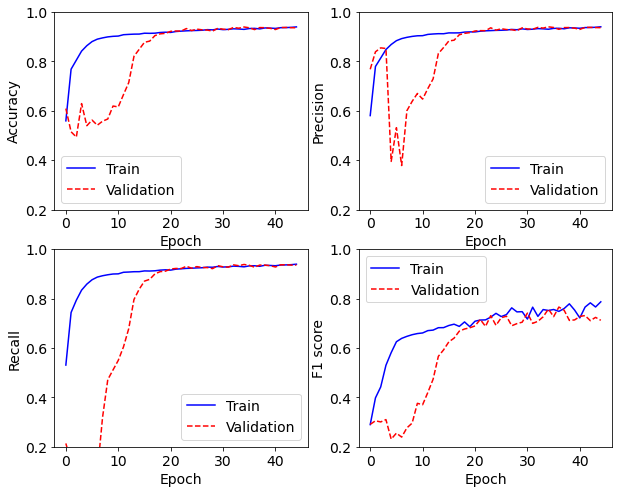

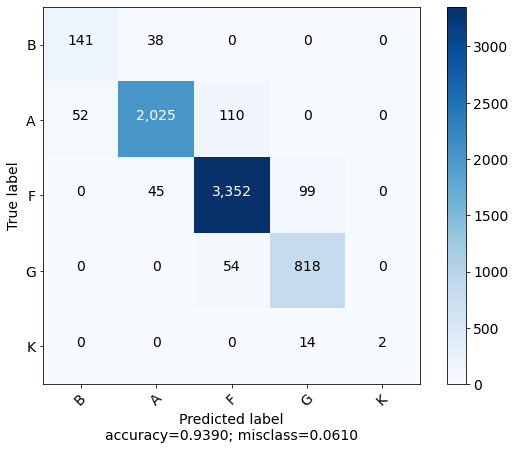

Test accuracy =  0.938962962962963
mu = -0.012148148148148148
sigma =  0.24675789659828049
RMSE =  0.24705674861666305
1st order poly fit: [0.9430053  0.11228151]


In [ ]:
"""
Basic CNN
"""

model_CNN.set_weights(initial_weights)
Basic_hs = model_CNN.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          callbacks = [early_stop],
          validation_data=(x_test, y_test)
          )
#test_accuracy = model_CNN.evaluate(x_test, y_test, verbose=0)
#print('\n', 'Test_Accuracy = ', test_accuracy[1])
#model_CNN.save('CNN_LAMOST.h5')

plot_metrics(Basic_hs)
prediction_CNN = model_CNN.predict(x_test)
predicted_label_CNN = np.zeros((len(label_test)))
for i in range(len(prediction_CNN)):
    predicted_label_CNN[i] = np.argmax(prediction_CNN[i])
cm_CNN = tf.math.confusion_matrix(label_test,predicted_label_CNN)
plot_confusion_matrix(np.array(cm_CNN), ["B","A","F","G","K"], title = "Confusion Matrix of the final model")
np.save('/content/drive/My Drive/CNN_prediction/main_CNN_basic_predict.npy', np.vstack([label_test,predicted_label_CNN]))
eva_basic = np.vstack([label_test,predicted_label_CNN])
evaluate(eva_basic)

{0: 5.978860476031951, 1: 1.7396061359390296, 2: 1.390560756629172, 3: 2.849602534408189, 4: 27.973978591914122}
Epoch 1/100
36/36 [==============================] - 2s 64ms/step - loss: 3.2372 - accuracy: 0.5910 - precision: 0.6527 - recall: 0.4064 - F1_score: 0.3228 - val_loss: 1.3434 - val_accuracy: 0.4244 - val_precision: 0.7297 - val_recall: 0.0480 - val_F1_score: 0.2318
Epoch 2/100
36/36 [==============================] - 2s 63ms/step - loss: 1.1626 - accuracy: 0.8046 - precision: 0.8304 - recall: 0.7559 - F1_score: 0.5394 - val_loss: 1.3313 - val_accuracy: 0.4213 - val_precision: 0.5556 - val_recall: 0.0333 - val_F1_score: 0.2363
Epoch 3/100
36/36 [==============================] - 2s 62ms/step - loss: 0.8101 - accuracy: 0.8555 - precision: 0.8631 - recall: 0.8442 - F1_score: 0.6524 - val_loss: 1.4078 - val_accuracy: 0.3387 - val_precision: 0.0762 - val_recall: 0.0182 - val_F1_score: 0.1702
Epoch 4/100
36/36 [==============================] - 2s 62ms/step - loss: 0.7277 - accura

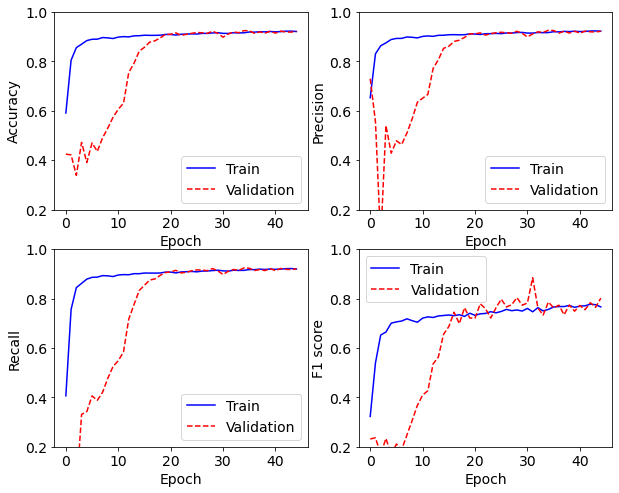

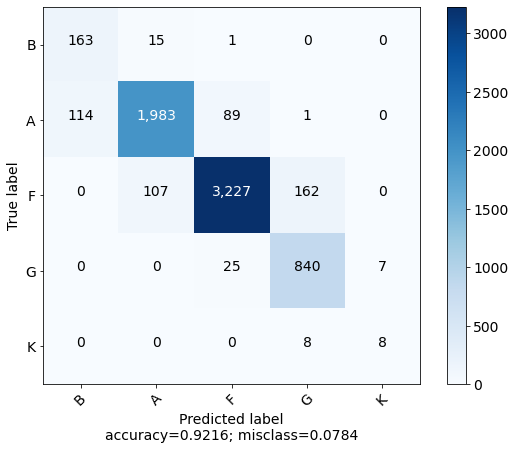

In [ ]:
"""
Class weightening
"""
_, counts_label_train = np.unique(label_train,return_counts= True)

class_weights_num = np.sqrt(1/counts_label_train * len(label_train))
class_weights = dict(zip(unique_classes-1,class_weights_num))
print(class_weights)


model_CNN.set_weights(initial_weights)
CW_hs = model_CNN.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          callbacks = [early_stop],
         validation_data=(x_val,y_val),
          class_weight = class_weights)
plot_metrics(CW_hs)

prediction_CW = model_CNN.predict(x_test)
predicted_label_CW = np.zeros((len(label_test)))
for i in range(len(prediction_CW)):
    predicted_label_CW[i] = np.argmax(prediction_CW[i])
cm_CW = tf.math.confusion_matrix(label_test,predicted_label_CW)
plot_confusion_matrix(np.array(cm_CW), ["B","A","F","G","K"], title = "Confusion Matrix of the final model")
np.save('/content/drive/My Drive/CNN_prediction/main_CNN_cw_predict.npy', np.vstack([label_test,predicted_label_CW]))

In [ ]:
"""
Oversampling 
"""
target_num = 4000
x_classed = [ [] for _ in range(5)]
y_classed = [ [] for _ in range(5)]
for i in range(len(x_train)):
    x_classed[label_train[i]].append(x_train[i])
    y_classed[label_train[i]].append(y_train[i])
print("classify data into list is done")

resampled_x = np.empty((0,4096,1))
resampled_y = np.empty((0,5))
for j in range(5):
    choices = np.random.choice(len(x_classed[j]),target_num)
    print("processing class :" ,j)
    for k in range(len(choices)):
        one_train_x = x_classed[j][choices[k]]
        one_train_y = y_classed[j][choices[k]]
        one_train_x = np.expand_dims(one_train_x,axis=0)
        one_train_y = np.expand_dims(one_train_y,axis=0)
        resampled_x = np.concatenate([resampled_x,one_train_x],axis = 0)
        resampled_y = np.concatenate([resampled_y,one_train_y],axis = 0)

order = np.arange(len(resampled_y))
np.random.shuffle(order)
resampled_x= resampled_x[order]
resampled_y = resampled_y[order]
model_CNN.set_weights(initial_weights)
re_hs = model_CNN.fit(resampled_x, resampled_y,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          callbacks = [early_stop],
         validation_data=(x_val,y_val))
plot_metrics(re_hs)

prediction_re = model_CNN.predict(x_test)
predicted_label_re = np.zeros((len(label_test)))
for i in range(len(prediction_re)):
    predicted_label_re[i] = np.argmax(prediction_re[i])
cm_re= tf.math.confusion_matrix(label_test,predicted_label_re)
plot_confusion_matrix(np.array(cm_re), ["B","A","F","G","K"], title = "Confusion Matrix of the final model")
np.save('/content/drive/My Drive/CNN_prediction/main_CNN_oversample_predict.npy', np.vstack([label_test,predicted_label_re]))

classify data into list is done
processing class : 0
processing class : 1
processing class : 2


KeyboardInterrupt: ignored

Epoch 1/100
40/40 [==============================] - 1s 35ms/step - loss: 0.9008 - accuracy: 0.6788 - precision: 0.7600 - recall: 0.6122 - F1_score: 0.6771 - val_loss: 1.5859 - val_accuracy: 0.0547 - val_precision: 0.0585 - val_recall: 0.0084 - val_F1_score: 0.0506
Epoch 2/100
40/40 [==============================] - 1s 34ms/step - loss: 0.3482 - accuracy: 0.8824 - precision: 0.8878 - recall: 0.8759 - F1_score: 0.8818 - val_loss: 1.5596 - val_accuracy: 0.0471 - val_precision: 0.1123 - val_recall: 0.0182 - val_F1_score: 0.0314
Epoch 3/100
40/40 [==============================] - 1s 35ms/step - loss: 0.2887 - accuracy: 0.9007 - precision: 0.9045 - recall: 0.8961 - F1_score: 0.9000 - val_loss: 1.4968 - val_accuracy: 0.1427 - val_precision: 0.0891 - val_recall: 0.0156 - val_F1_score: 0.1076
Epoch 4/100
40/40 [==============================] - 1s 34ms/step - loss: 0.2487 - accuracy: 0.9173 - precision: 0.9198 - recall: 0.9147 - F1_score: 0.9166 - val_loss: 1.4852 - val_accuracy: 0.1356 - va

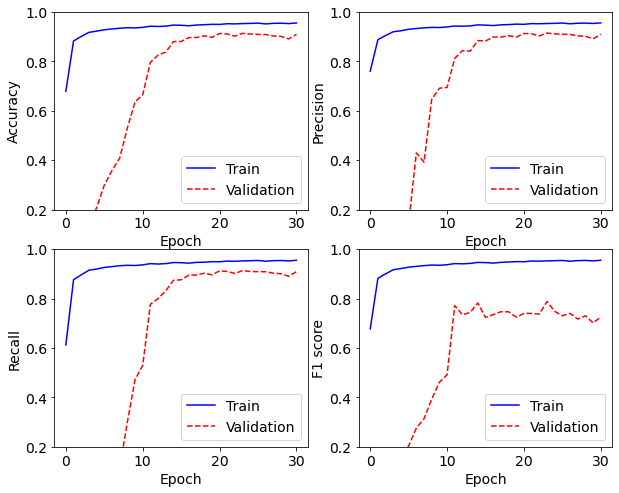

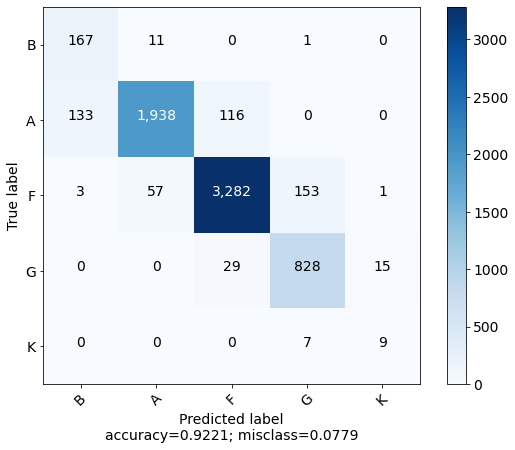

In [ ]:
model_CNN.set_weights(initial_weights)
re_hs = model_CNN.fit(resampled_x, resampled_y,
          batch_size=500,
          epochs=EPOCHS,
          callbacks = [early_stop],
         validation_data=(x_val,y_val))
plot_metrics(re_hs)

prediction_re = model_CNN.predict(x_test)
predicted_label_re = np.zeros((len(label_test)))
for i in range(len(prediction_re)):
    predicted_label_re[i] = np.argmax(prediction_re[i])
cm_re= tf.math.confusion_matrix(label_test,predicted_label_re)
plot_confusion_matrix(np.array(cm_re), ["B","A","F","G","K"], title = "Confusion Matrix of the final model")
np.save('/content/drive/My Drive/CNN_prediction/main_CNN_oversample_predict.npy', np.vstack([label_test,predicted_label_re]))

93080
data processed
Epoch 1/100
94/94 [==============================] - 6s 63ms/step - loss: 0.8624 - accuracy: 0.7391 - precision: 0.7999 - recall: 0.6635 - F1_score: 0.7379 - val_loss: 2.0287 - val_accuracy: 0.0284 - val_precision: 0.0583 - val_recall: 0.0222 - val_F1_score: 0.0205
Epoch 2/100
94/94 [==============================] - 6s 61ms/step - loss: 0.2801 - accuracy: 0.9043 - precision: 0.9073 - recall: 0.9009 - F1_score: 0.9036 - val_loss: 2.1270 - val_accuracy: 0.0320 - val_precision: 0.0518 - val_recall: 0.0262 - val_F1_score: 0.0187
Epoch 3/100
94/94 [==============================] - 6s 61ms/step - loss: 0.2276 - accuracy: 0.9242 - precision: 0.9260 - recall: 0.9219 - F1_score: 0.9235 - val_loss: 1.9116 - val_accuracy: 0.1609 - val_precision: 0.0584 - val_recall: 0.0307 - val_F1_score: 0.1592
Epoch 4/100
94/94 [==============================] - 6s 61ms/step - loss: 0.2037 - accuracy: 0.9316 - precision: 0.9331 - recall: 0.9295 - F1_score: 0.9310 - val_loss: 1.3581 - val_

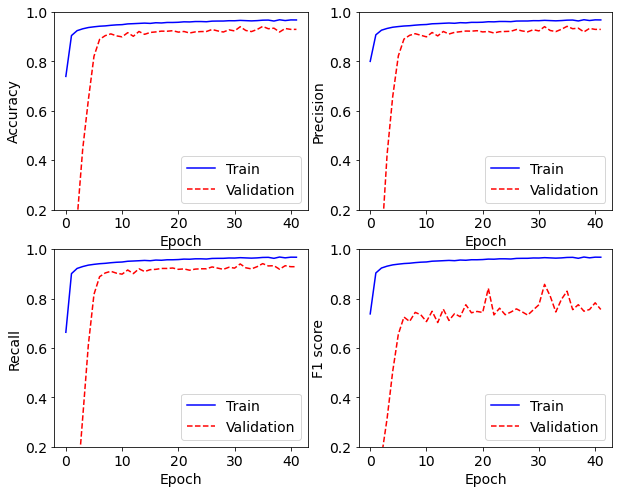

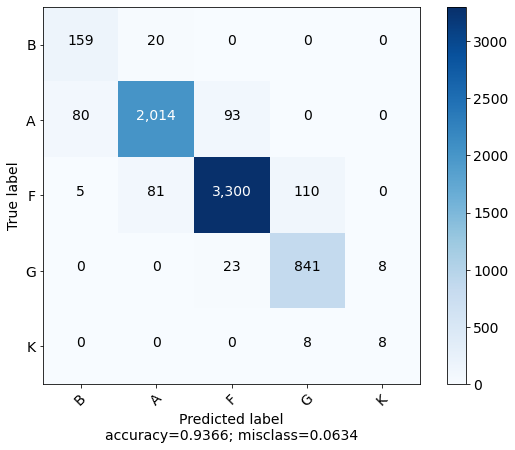

In [ ]:
"""
Smote sampling
"""
spectra_smote = np.load("/content/drive/My Drive/CNN_spectra_data/class_spectra_smote.npy")
label_smote = np.load("/content/drive/My Drive/CNN_spectra_data/class_label_smote.npy")
print(len(label_smote))
"""
Wrong labeled experiment.
for i in range(len(label_smote)):
    if np.random.random(1)<0.1:
        label_smote[i] = np.random.randint(5)
"""
x_smote = np.expand_dims(spectra_smote, axis=2)
y_smote = tf.one_hot(label_smote, depth = 5, axis = 1 ,dtype=tf.int8)
print("data processed")
model_CNN.set_weights(initial_weights)
re_hs = model_CNN.fit(x_smote, y_smote,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          callbacks = [early_stop],
         validation_data=(x_val,y_val))
#tf.saved_model.save( model_CNN, "/content/drive/My Drive/CNN_models/main_class_model")

plot_metrics(re_hs)

prediction_smote = model_CNN.predict(x_test)
predicted_label_smote = np.zeros((len(label_test)))
for i in range(len(prediction_smote)):
    predicted_label_smote[i] = np.argmax(prediction_smote[i])
cm_smote= tf.math.confusion_matrix(label_test,predicted_label_smote)
plot_confusion_matrix(np.array(cm_smote), ["B","A","F","G","K"], title = "Confusion Matrix of the final model")
#np.save('/content/drive/My Drive/CNN_prediction/main_CNN_smote_predict.npy', np.vstack([label_test,predicted_label_smote]))

In [ ]:
eva_smote = np.vstack([label_test,predicted_label_smote])
evaluate(eva_smote)
micro_scores(cm_smote)

Test accuracy =  0.9417777777777778
mu = 0.001925925925925926
sigma =  0.24128512807786157
RMSE =  0.24129281427805144
1st order poly fit: [0.95722148 0.07323118]
print percisions; recalls; F1 scores
[0.72368421 0.9615019  0.95344877 0.90950226 0.54545455]
[0.92178771 0.92501143 0.96081236 0.92201835 0.375     ]
[0.81081081 0.94290375 0.9571164  0.91571754 0.44444444]


(array([0.72368421, 0.9615019 , 0.95344877, 0.90950226, 0.54545455]),
 array([0.92178771, 0.92501143, 0.96081236, 0.92201835, 0.375     ]),
 array([0.81081081, 0.94290375, 0.9571164 , 0.91571754, 0.44444444]))

In [ ]:
eva_smote = np.vstack([label_test,predicted_label_smote])
evaluate(eva_smote)
micro_scores(cm_smote)

Test accuracy =  0.9365925925925926
mu = -0.004296296296296296
sigma =  0.25614677719573997
RMSE =  0.2561828051014151
1st order poly fit: [0.97763123 0.04359573]
print percisions; recalls; F1 scores
[0.65163934 0.95224586 0.96604215 0.87695516 0.5       ]
[0.88826816 0.9208962  0.94393593 0.96444954 0.5       ]
[0.75177305 0.93630869 0.95486111 0.9186237  0.5       ]


(array([0.65163934, 0.95224586, 0.96604215, 0.87695516, 0.5       ]),
 array([0.88826816, 0.9208962 , 0.94393593, 0.96444954, 0.5       ]),
 array([0.75177305, 0.93630869, 0.95486111, 0.9186237 , 0.5       ]))

In [ ]:
"""
'''
Oversampling with tf database
'''

BUFFER_SIZE = 20000


def make_ds(features, labels, target_num):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat(np.ceil(target_num/len(labels)))
  return ds

x_classed = [[]]*5
y_classed = [[]]*5
for i in range(len(x_train)):
    x_classed[label_train[i]].append(x_train[i])
    y_classed[label_train[i]].append(y_train[i])
print("classify data done")
data_classed=[]
for j in range(5):
    data_classed.append(make_ds(x_classed[j],y_classed[j], target_num = 20000))
print("make_ds done")

resampled_ds = tf.data.experimental.sample_from_datasets(data_classed, weights=[1/5]*5)
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(10)
resampled_steps_per_epoch = np.ceil(BUFFER_SIZE/(BATCH_SIZE*0.2))

"""

'\n\'\'\'\nOversampling with tf database\n\'\'\'\n\nBUFFER_SIZE = 20000\n\n\ndef make_ds(features, labels, target_num):\n  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()\n  ds = ds.shuffle(BUFFER_SIZE).repeat(np.ceil(target_num/len(labels)))\n  return ds\n\nx_classed = [[]]*5\ny_classed = [[]]*5\nfor i in range(len(x_train)):\n    x_classed[label_train[i]].append(x_train[i])\n    y_classed[label_train[i]].append(y_train[i])\nprint("classify data done")\ndata_classed=[]\nfor j in range(5):\n    data_classed.append(make_ds(x_classed[j],y_classed[j], target_num = 20000))\nprint("make_ds done")\n\nresampled_ds = tf.data.experimental.sample_from_datasets(data_classed, weights=[1/5]*5)\nresampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(10)\nresampled_steps_per_epoch = np.ceil(BUFFER_SIZE/(BATCH_SIZE*0.2))\n\n'

93080
data processed
Epoch 1/100
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
94/94 [==============================] - 7s 74ms/step - loss: 1.0459 - accuracy: 0.7047 - precision: 0.7805 - recall: 0.5810 - F1_score: 0.7028 - val_loss: 1.9822 - val_accuracy: 0.0311 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_F1_score: 0.0121
Epoch 2/100
94/94 [==============================] - 6s 64ms/step - loss: 0.6067 - accuracy: 0.8457 - precision: 0.8591 - recall: 0.8199 - F1_score: 0.8449 - val_loss: 2.2602 - val_accuracy: 0.0436 - val_precision: 0.0295 - val_recall: 0.0267 - val_F1_score: 0.0263
Epoch 3/100
94/94 [==============================] - 6s 64ms/step - loss: 0.5681 - accuracy: 0.8569 - precision: 0.8681 - recall: 0.8386 - F1_score: 0.8562 - val_loss: 2.4563 - val_accuracy: 0.0351 - val_precision: 0.0317 - val_recall: 0.0311 - val_F1_score: 0.0165
Epoch 4/100
94/94 [==============================] - 6s 64ms/step - loss: 0.5509 - accuracy:

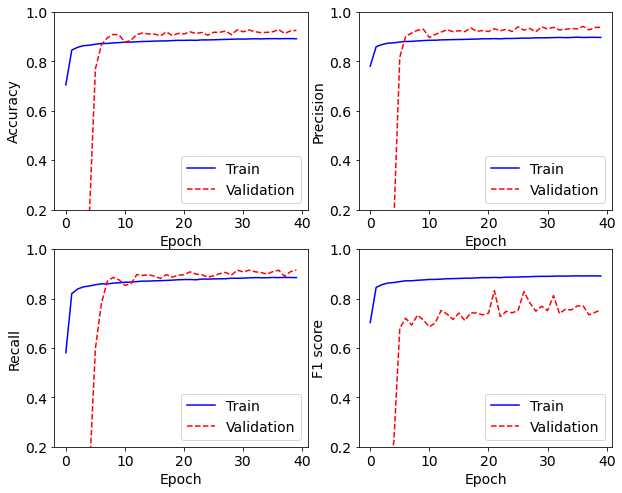

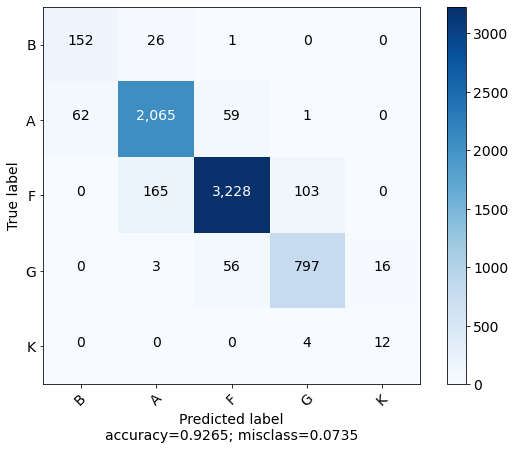

In [7]:
"""
incorrect labels
"""
spectra_smote = np.load("/content/drive/My Drive/CNN_spectra_data/class_spectra_smote.npy")
label_smote = np.load("/content/drive/My Drive/CNN_spectra_data/class_label_smote.npy")
print(len(label_smote))

#Wrong labeled experiment.
for i in range(len(label_smote)):
    if np.random.random(1)<0.1:
        label_smote[i] = np.random.randint(5)

x_smote = np.expand_dims(spectra_smote, axis=2)
y_smote = tf.one_hot(label_smote, depth = 5, axis = 1 ,dtype=tf.int8)
print("data processed")
model_CNN.set_weights(initial_weights)
re_hs = model_CNN.fit(x_smote, y_smote,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          callbacks = [early_stop],
         validation_data=(x_val,y_val))
#tf.saved_model.save( model_CNN, "/content/drive/My Drive/CNN_models/main_class_model")

plot_metrics(re_hs)

prediction_smote = model_CNN.predict(x_test)
predicted_label_smote = np.zeros((len(label_test)))
for i in range(len(prediction_smote)):
    predicted_label_smote[i] = np.argmax(prediction_smote[i])
cm_smote= tf.math.confusion_matrix(label_test,predicted_label_smote)
plot_confusion_matrix(np.array(cm_smote), ["B","A","F","G","K"], title = "Confusion Matrix of the final model")
#np.save('/content/drive/My Drive/CNN_prediction/main_CNN_smote_predict.npy', np.vstack([label_test,predicted_label_smote]))

In [8]:
evaluate(np.vstack([label_test,predicted_label_smote]))

Test accuracy =  0.9265185185185185
mu = 0.012592592592592593
sigma =  0.2748547440294613
RMSE =  0.27514306043166653
1st order poly fit: [0.96230745 0.05362904]
